# Geo art experiment with OpenStreetMap
In the Sendling Westpark quarter of Munich, many streets are named after towns or other locations in southern Bavaria and Tyrol. Do the locations of the streets resemble the locations of the corresponding places in Bavaria? Let's find out...

In [1]:
%matplotlib inline
import collections
import itertools
import cartopy.crs
import cartopy.io.img_tiles
import matplotlib.pyplot as plt
import requests
from PIL import Image

In [2]:
plt.rcParams['figure.figsize'] = [12, 10]

In [23]:
# Some simple coordinate types
Location = collections.namedtuple('Location', ['latitude', 'longitude'])

class BBox(collections.namedtuple('BBox', ['west', 'south', 'east', 'north'])):
    @property
    def snwe(self):
        return (self.south, self.north, self.west, self.east)
    @property
    def wesn(self):
        return (self.west, self.east, self.south, self.north)
    @property
    def swne(self):
        return (self.south, self.west, self.north, self.east)

## Parameters
Now, let's define the areas of interest, and some information about them. If you want to apply this notebook to other areas, change settings here

In [25]:
# Boundary box of the quarter:
quarter_bbox = BBox(west=11.497664451599, east=11.531610488892, south=48.102014896263, north=48.123819875866)

# Boundary box of the region containing the locations after which the streets in the quarter are named:
region_bbox = BBox(west=10.5, east=12.5, south=47.2, north=48.2)

# For the map of the region, we use a slightly wider bbox to cover some outliers:
region_map_bbox = BBox(west=10.3, east=12.0, south=47.2, north=48.2)

# The remaining parameters are used to map the street names to the names of the corresponding locations. 
# We try to do this algorithmically for the most part, but some manual work is needed as natural language
# doesn't follow strict algorithmical rules ;-)

# Street name suffixes that need to be stripped
suffixes = 'straße platz allee tunnel weg ring brücke er'.split()

# Street names that don't map to locations in the region. We want to ignore them in order to reduce the load on the overpass server
ignored = '''
Asperstraße Beerweg Billrothstraße Cimbernstraße Dauthendeystraße
Döderleinstraße Ebermayerstraße Einseleweg Euckenstraße Gerokstraße
Gilmstraße Grabbeweg Guardinistraße Güßfeldtweg Hauffstraße
Heckenstallerstraße Heckenstallertunnel Hertlstraße Hiltnerweg
Hirnerstraße Hofmannstraße Hölderlinstraße Höltystraße
Innerkoflerstraße Kaltnerweg Kederbacherstraße Kirchgrabnerweg
Klingerstraße Kornwegerstraße Kriegersiedlung Kurparkstraße
Köglspergerweg Leostraße Markomannenstraße Millauerweg Mäuselweg
Nothkaufplatz Nothkaufstraße Novalisstraße Ohlenschlagerstraße
Ossingerstraße Partenhauserweg Pfundmayerstraße Pirmaterstraße
Plazerstraße Riedmaierweg Sappelstraße Schietweg Schinnaglstraße
Schlegelstraße Schmuzerstraße Schneemannstraße Schottenloherweg
Schulenburgstraße Slevogtstraße Specklinplatz Taeutterstraße
Toemlingerstraße Trautweinstraße Trischbergerweg Vingerstraße
Voglmaierstraße Wadlerstraße Wallmenichstraße Zegginstraße
Zielstattstraße Zwergerweg Öcklweg Ötschmannweg
'''.split()

# Irregular street name mappings
irregular = {
    'Eschenloher Straße': 'Eschenlohe',
    'Hochwannerstraße': 'Hochwanner',
    'Laberstraße': 'Laber',
    'Ortlerstraße': 'Ortler',
    'Partenkirchner Straße': 'Partenkirchen',
    'Seehauser Straße': 'Seehausen',
    'Werdenfelsstraße': 'Werdenfelser Land',
}

In [5]:
# Now we run a first overpass query to find streets in our quarter
overpass = "https://lz4.overpass-api.de/api/interpreter"

street_query = f'[out:json];way["highway"]["name"]{quarter_bbox.swne};(._;>;);out body qt;'

street_response = requests.post(overpass, data={'data':street_query})

In [6]:
# Extract the stree names from the response, resulting in a mapping from street name to a list of paths
def extract_streets(response):
    "Extract streets from an overpass response."
    data = response.json()['elements']    
    nodes = [e for e in data if e['type']=='node']
    ways = [e for e in data if e['type']=='way']
    node_map = {n['id']: Location(n['lat'], n['lon']) for n in nodes}

    streets = collections.defaultdict(list)
    for w in ways:
        name = w['tags']['name']
        path = [node_map[n] for n in w['nodes']]
        streets[name].append(path)
    
    return streets

streets = extract_streets(street_response)

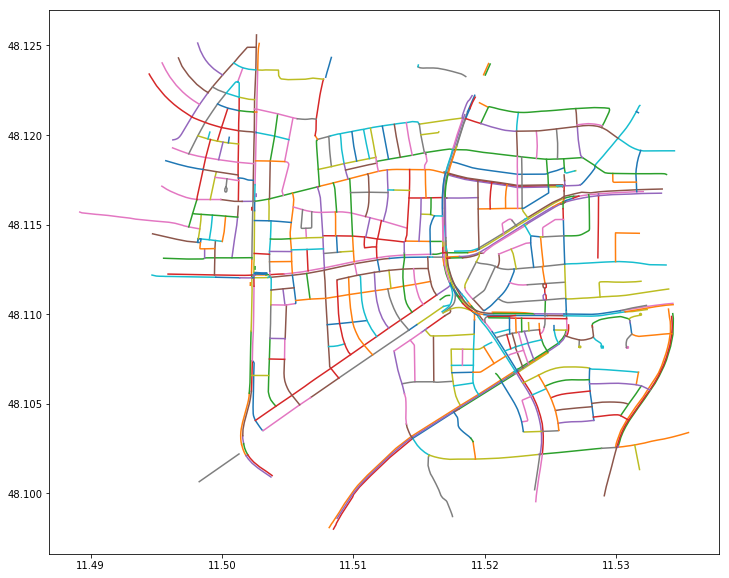

In [7]:
# Plot a simple map of the streets for verification:
for name, paths in streets.items():
    for path in paths:
        plt.plot ([loc.longitude for loc in path], [loc.latitude for loc in path])

## Map street names to place names
Clean up the street names and find corresponding place names

> ### eponymous adjective
> epon·​y·​mous | \ i-ˈpä-nə-məs  , e-\
> of, relating to, or being the person or thing for whom or which something is named

[(Merriam-Webster)](https://www.merriam-webster.com/dictionary/eponymous)

In [8]:
def trim_suffixes(s):
    for suffix in suffixes:
        if s.lower().endswith(suffix):
            s = s[:-len(suffix)].strip()
    return s

def eponymous_location(street_name):
    if street_name in ignored:
        return None
    if street_name in irregular:
        return irregular[street_name]
    s = trim_suffixes(street_name.replace('-', ' '))
    if ' ' in s: # typically a person's name
        return None
    return s                

In [9]:
street_to_place = {s: eponymous_location(s) for s in streets.keys()}
place_names = set(street_to_place.values()) - {None}

In [10]:
' '.join(sorted(place_names))

'Aichach Aidenbach Alpsee Alpspitz Ammergau Arnim Badersee Badgastein Banat Barbi Bela Bernried Bielitz Boschetsried Breitbrunn Bruneck Drachensee Echelsbach Ehrenfels Ehrwald Eibsee Eichendorff Einhorn Elmau Eschenlohe Esterberg Ettal Farchant Fernpaß Fürstenried Garmisch Grabbe Grainau Graswang Grün Habach Hahndorf Hallgarten Halm Hammersbach Harmating Heiterwang Herrsching Heuwinkel Hinterbärenbad Hochwanner Holstein Holzapfelkreuth Holzhausen Höglwörth Höllental Iffeldorf Illing Inning Juifen Kiefersfelden Klais Kohlgrub Krottenkopf Krün Kuhflucht Kössen Küchel Laber Lermoos Leutasch Linderhof Loisach Mainburg Mittenwald Murnau Netzegau Neufriedenheim Niederwald Oberau Oetztal Ohlstadt Olympia Ortler Osterseen Ostmark Partenkirchen Partnach Passau Penzberg Pfaffenwinkel Pilsensee Polling Preßburg Pähl Raiding Ramsau Rattenberg Reuland Rheinstein Rießersee Rottenbuch Sachsenkam Scharnitz Schondorf Schongau Schröfelhof Schüsselkar Seebensee Seefeld Seehausen Siebenbürgen Stahleck Sta

## Find the places

In [11]:
# Now run a batch of overpass queries to find the places
query_template = """\
[out:json]
[timeout:25]
;
(
  node ["name"="{name}"]; 
  way ["name"="{name}"]; 
  relation ["name"="{name}"];
);
out ids center;
"""
place_data = {}
for name in place_names:
    query = query_template.format(name=name)
    response = requests.post(overpass, data={'data':query})
    elements = response.json()['elements']
    #print (name, len(elements))
    if elements:
        place_data[name] = elements

In [12]:
place_data = {name: elements for (name, elements) in place_data.items() if elements}

In [13]:
# for many street names, `place_data` contains multiple locations. Select the place that is closest to the center of the quarter of interest:

center = Location((quarter_bbox.south + quarter_bbox.north) / 2, (quarter_bbox.west + quarter_bbox.east) / 2)

def element_location(e):
    center = e if e['type'] == 'node' else e ['center']
    return Location(center['lat'], center['lon'])

def d2_from_center(e):
    location = element_location(e)
    return (location.latitude - center.latitude) ** 2 + (location.longitude - center.longitude) ** 2

locations= {}
for (name, elements) in place_data.items():
        e = sorted(elements, key=d2_from_center)
        locations[name] = element_location(e[0])

## Color Coding
To provide a visual link between the location of a place in the region of interest, and the corresponding street, we use color coding via a [2D color map](https://dominikjaeckle.com/projects/color2d/):
![ziegler color map](ziegler.png)

In [14]:
# Define a helper class to perform the mapping

class ColorMap2D:
    "When called, maps 2D data points to an RGB color"
    
    def __init__(self, map_range, map_path='ziegler.png'):
        '''Create a new 2D color map.
        
        `map_range` is a pair of 2D data points defining the range of data.
        `map_path`is an image file that defines the color map.'''
        self.image = Image.open(map_path)
        self.offset = map_range[0]
        d = map_range[1]
        self.scale = (d[0] - self.offset[0], d[1] - self.offset[1])
    
    def __call__(self, point):
        'Maps `point` to an RGB color'
        xy = (self.normalize(point[0], 0), self.normalize(point[1], 1))
        rgb_255 = self.image.getpixel(xy)
        rgb = [v / 255. for v in rgb_255]
        return rgb
    
    def normalize(self, value, axis):
        'Helper to scale and clip `value` to the interval `(0, image.size[axis])`. `axis` = 0/1 for x/y.'
        return  min(self.image.size[axis] - 1, self.image.size[axis] * max(0,  (value - self.offset[axis]) / self.scale[axis]))

In [30]:
# Now do the mapping

colormap = ColorMap2D((Location(region_bbox.west, region_bbox.north), Location(region_bbox.east, region_bbox.south)))

location_name_to_color={}
for name, loc in locations.items():
    c = colormap((loc.longitude, loc.latitude))
    location_name_to_color[name] = c

## Drawing the maps
Now we are almost ready to draw some real maps. However, plotting just the plain streets, as we did in the quick check above above, is a bit bland. Let's add some nice background map from [Stamen](http://maps.stamen.com/)

In [31]:
stamen_terrain = cartopy.io.img_tiles.Stamen('terrain')

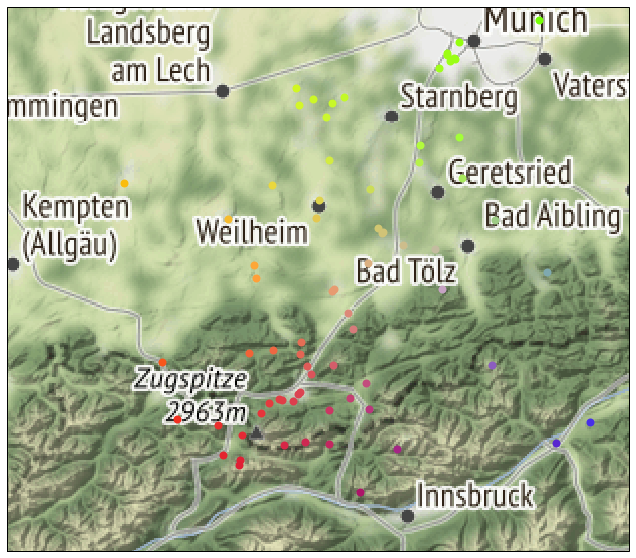

In [32]:
# First, lets draw the locations of the various places referenced by the street names:
def plot_locations(ax):    
    ax.set_extent(region_map_bbox.wesn)

    ax.add_image(stamen_terrain, 8)

    for name, loc in locations.items():
        ax.plot(loc.longitude, loc.latitude, marker='o', linewidth=0, markerfacecolor=location_name_to_color[name], markersize=8, markeredgewidth=0, transform=cartopy.crs.Geodetic())
    
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)
plot_locations(ax)
plt.show()

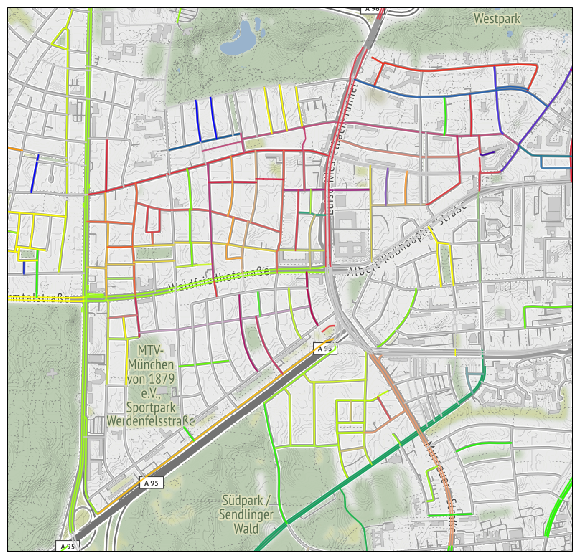

In [33]:
# Now, let's draw a map of the quarter, with the street names color-coded
def plot_streets(ax):    
    ax.set_extent(quarter_bbox.wesn)

    ax.add_image(stamen_terrain, 15)

    for name, paths in streets.items():
        c = location_name_to_color.get(street_to_place[name], (0.8, 0.8, 0.8))
        for path in paths:
            ax.plot ([loc.longitude for loc in path], [loc.latitude for loc in path], color=c, transform=cartopy.crs.Geodetic())
    
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(1, 1, 1, projection=stamen_terrain.crs)
plot_streets(ax)
plt.show()

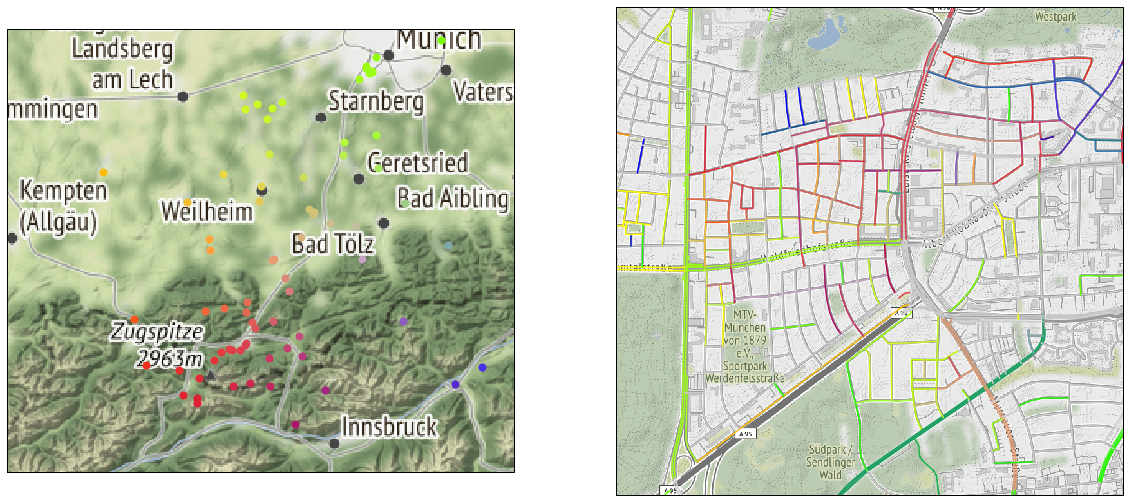

In [34]:
# Finally, combine both plots
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection=stamen_terrain.crs)
plot_locations(ax)
ax = fig.add_subplot(1, 2, 2, projection=stamen_terrain.crs)
plot_streets(ax)
plt.show()

## Attributions
* Map tiles by [Stamen Design](http://stamen.com), under [CC BY 3.0](http://creativecommons.org/licenses/by/3.0). 
* Data by [OpenStreetMap](http://openstreetmap.org), under [ODbL](http://www.openstreetmap.org/copyright)
* Openstreedmap queries using the [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API)
* Ziegler color map by [Dominik Jäckle](https://dominikjaeckle.com/projects/color2d/) based on **Explorative Analysis of 2D Color Maps** Steiger, M., Bernard, J., Mittelstädt, S., Hutter, M., Keim, D., Thum, S., Kohlhammer, J. *Proceedings of WSCG (23), 151-160, Eurographics Assciation, Vaclav Skala - Union Agency, 2015*
* Map drawing using [cartopy](https://github.com/SciTools/cartopy) and
* [Matplotlib](https://matplotlib.org) by [Hunter et al (2007)](https://doi.org/10.1109/MCSE.2007.55)